#Business Background
LendingClub, based in San Francisco, California, is a pioneering peer-to-peer lending company in the US. It set a precedent by becoming the first of its kind to register its services as securities with the Securities and Exchange Commission (SEC) and introduced loan trading on a secondary market. Today, it stands as the globe's premier peer-to-peer lending platform.

You are part of the LendingClub team, a company that offers diverse loan options to urban clients. Whenever a loan request is submitted, LendingClub must evaluate the applicant's profile to make an informed loan approval decision. The outcome hinges on two potential risks:

* Denying a loan to an applicant who is capable of repayment means missed business opportunities for LendingClub.
* Conversely, approving a loan to an applicant prone to defaulting can spell financial setbacks for the company.

The provided dataset encompasses historical data on loan applicants, highlighting who defaulted and who didn't. The goal is to discern patterns that signal the likelihood of an applicant defaulting. Such insights can guide strategies like denying the loan, adjusting the loan amount, or setting higher interest rates for riskier borrowers.

Curated from https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook by Fares Sayah

# Settings

In [ ]:
# ! pip install -q shap

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Recall

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Load Data

Note: the data has been cleaned up and transformed. To learn more about the original data, check here
https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook

In [ ]:
data_url = 'https://raw.githubusercontent.com/JHU-CDHAI/Dataset/main/lending_club_loan_processed.csv'

data = pd.read_csv(data_url)
print(data.shape)
data.head()

(395219, 81)


,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,loan_status
0,10000.00,36,11.44,329.48,117000.00,26.24,1990,16.00,0,36369.00,41.80,25.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,8000.00,36,11.99,265.68,65000.00,22.05,2004,17.00,0,20131.00,53.30,27.00,1.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,15600.00,36,10.49,506.97,43057.00,12.79,2007,13.00,0,11987.00,92.20,26.00,0.00,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,7200.00,36,6.49,220.65,54000.00,2.60,2006,6.00,0,5472.00,21.50,13.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,24375.00,60,17.27,609.33,55000.00,33.95,1999,13.00,0,24584.00,69.80,43.00,1.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
# 0: means Fully Paid
# 1: means Charged Off
data['loan_status'].value_counts()

loan_status
0    317696
1     77523
Name: count, dtype: int64

In [ ]:
data.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,loan_status
0,10000.00,36,11.44,329.48,117000.00,26.24,1990,16.00,0,36369.00,41.80,25.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,8000.00,36,11.99,265.68,65000.00,22.05,2004,17.00,0,20131.00,53.30,27.00,1.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,15600.00,36,10.49,506.97,43057.00,12.79,2007,13.00,0,11987.00,92.20,26.00,0.00,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,7200.00,36,6.49,220.65,54000.00,2.60,2006,6.00,0,5472.00,21.50,13.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,24375.00,60,17.27,609.33,55000.00,33.95,1999,13.00,0,24584.00,69.80,43.00,1.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_im

In [ ]:
data.shape

(395219, 81)

In [ ]:
# Comment this out if you want to use Zip Code information.
new_cols = [i for i in data.columns if 'zip' not in i]
data = data[new_cols]

In [ ]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_im

# Data preparation

In [ ]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

# (264796, 81)
# (130423, 81)

(264796, 72)
(130423, 72)


In [ ]:
# Removing outliers
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)

(264796, 72)
(262143, 72)


In [ ]:
# Normalizing the data
X_train, y_train = train.drop('loan_status', axis=1), train['loan_status']
X_test,  y_test  = test.drop('loan_status', axis=1),  test['loan_status']

In [ ]:
# y_train

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.array(X_train).astype(np.float32)
X_test  = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test  = np.array(y_test).astype(np.float32)

# Simple Neural Network model

## Build Model

In [ ]:
# Build a simple neural network model
model = Sequential()
#Add dense layer with 128 nodes. Normalize output, no regularization
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0))
#Add dense layer with 128 nodes. Normalize output, 10% dropout rate to control overfitting
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
#Add dense layer with 128 nodes. Normalize output, no regularization
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0))
#Add dense layer with 128 nodes. Normalize output, 10% dropout rate to control overfitting
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use sigmoid activation

## Train Model

In [ ]:
# Compile the model; adjusted learning rate to 0.0005 for additional precision
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0005), metrics=[Recall(), 'accuracy'])

Epoch 1/30
6554/6554 [==============================] - 27s 4ms/step - loss: 0.4764 - recall_3: 0.0736 - accuracy: 0.7941 - val_loss: 0.4550 - val_recall_3: 0.0701 - val_accuracy: 0.8051
Epoch 2/30
6554/6554 [==============================] - 26s 4ms/step - loss: 0.4575 - recall_3: 0.0491 - accuracy: 0.8036 - val_loss: 0.4528 - val_recall_3: 0.0653 - val_accuracy: 0.8063
Epoch 3/30
6554/6554 [==============================] - 25s 4ms/step - loss: 0.4560 - recall_3: 0.0414 - accuracy: 0.8034 - val_loss: 0.4518 - val_recall_3: 0.0509 - val_accuracy: 0.8052
Epoch 4/30
6554/6554 [==============================] - 24s 4ms/step - loss: 0.4544 - recall_3: 0.0487 - accuracy: 0.8038 - val_loss: 0.4541 - val_recall_3: 0.0935 - val_accuracy: 0.8053
Epoch 5/30
6554/6554 [==============================] - 24s 4ms/step - loss: 0.4537 - recall_3: 0.0482 - accuracy: 0.8038 - val_loss: 0.4509 - val_recall_3: 0.0936 - val_accuracy: 0.8049
Epoch 6/30
6554/6554 [==============================] - 27s 4ms/s

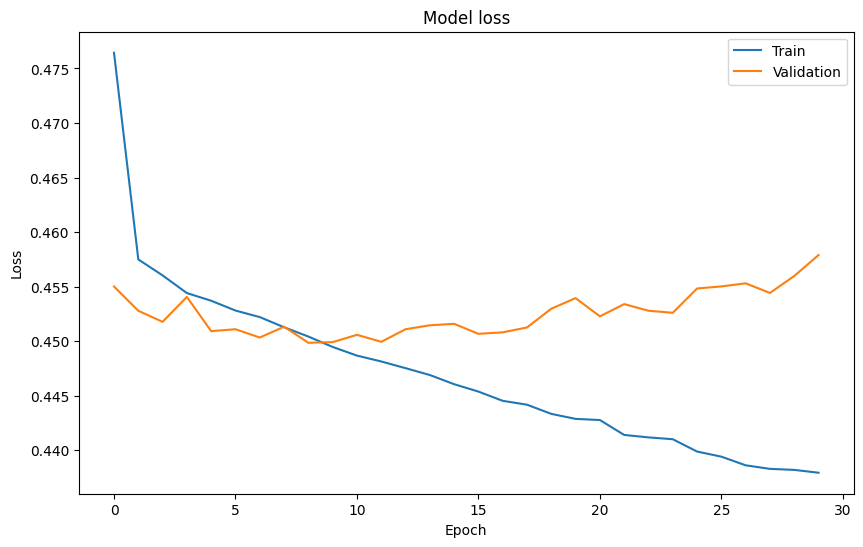

In [ ]:
# Train the model, adjusted epochs to 30 and batch size to 32
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate Model

In [ ]:
# assuming 'model' is your trained model
test_loss, test_recall, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy}')
print(f'Test recall: {test_recall}')

4076/4076 - 6s - loss: 0.4548 - recall_3: 0.1262 - accuracy: 0.8041 - 6s/epoch - 2ms/step
Test accuracy: 0.8041372895240784
Test recall: 0.12621663510799408


In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

4076/4076 [==============================] - 7s 2ms/step


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[101662,   3281],
       [ 22264,   3216]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Assuming y_pred and y_test are numpy arrays or lists containing binary labels (0 or 1)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.49499769124211174
Recall: 0.1262166405023548


Text(95.72222222222221, 0.5, 'Truth')

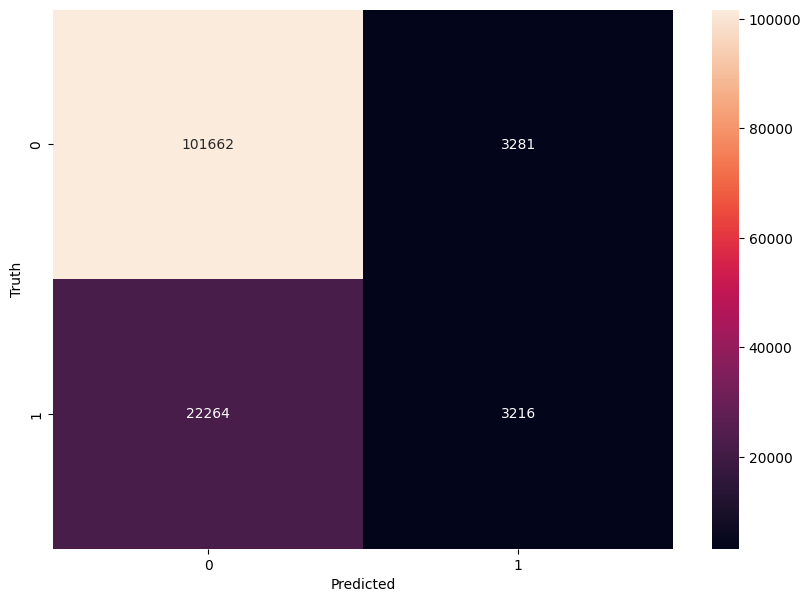

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Questions to think:

1. How good is the model performance?
2. Can you think of ways to further improve the model performance?